<span style="color: black; font-weight: bold; font-size: 50px;">Automatisation de la détection et du traitement des doublons</span>

In [ ]:
import requests
import pandas as pd
import time
from datetime import datetime
from dateutil import parser as date_parser
import pytz

API_KEY = ""
DOMAIN = ""
VIEW_ID = ""
BASE_URL = f"https://{DOMAIN}.myfreshworks.com/crm/sales/"
HEADERS = {
    "Content-Type": "application/json",
    "Authorization": f"Token token={API_KEY}"
}
LOCAL_TZ = pytz.timezone("Europe/Paris")

def safe_get(url, params=None):
    while True:
        response = requests.get(url, headers=HEADERS, params=params)
        if response.status_code == 429:
            print("Rate limit (429). Pause 5 minutes...")
            time.sleep(300)
            continue
        return response

def fetch_data(endpoint):
    url = f"{BASE_URL}api/selector/{endpoint}"
    response = safe_get(url)
    if response.status_code == 200:
        return {item["id"]: item["name"] for item in response.json().get(endpoint, [])}
    return {}

def get_contact_statuses():
    url = f"{BASE_URL}api/selector/contact_statuses"
    response = safe_get(url)
    if response.status_code == 200:
        return response.json().get("contact_statuses", [])
    return []

def build_status_mappings():
    statuses = get_contact_statuses()
    status_id_to_name = {}
    status_id_to_lifecycle_id = {}

    lifecycle_id_to_name = {
        32012758207: "Sarah Nacass Accompagnement",
        32019529362: "Sarah Nacass Formation",
        32022743043: "Stage de sensibilisation",
        32023906873: "OLC Accompagnement",
        32012758208: "Sales Qualified Lead",
        32012758209: "Fermé - Gagné/Perdu"
    }

    for status in statuses:
        sid = status.get("id")
        status_id_to_name[sid] = status.get("name")
        status_id_to_lifecycle_id[sid] = status.get("lifecycle_stage_id")

    return status_id_to_name, status_id_to_lifecycle_id, lifecycle_id_to_name

def get_deal_metadata():
    pipelines = fetch_data("deal_pipelines")
    deal_stages = {}
    for pid in pipelines:
        url = f"{BASE_URL}api/selector/deal_pipelines/{pid}/deal_stages"
        resp = safe_get(url)
        if resp.status_code == 200:
            stages = resp.json().get("deal_stages", [])
            deal_stages.update({s["id"]: s["name"] for s in stages})
    lifecycle_stages = fetch_data("lifecycle_stages")
    owners = fetch_data("owners")
    return pipelines, deal_stages, lifecycle_stages, owners

def get_contact_notes(contact_id):
    url = f"{BASE_URL}api/contacts/{contact_id}/notes"
    response = safe_get(url, params={'per_page': 5, 'sort': 'created_at.desc'})
    if response.status_code != 200:
        return ""
    notes = response.json().get("notes", [])
    return " || ".join(n.get("description", "") for n in notes if n.get("description"))

def get_contact_deals(contact_id, pipelines, deal_stages, lifecycle_stages, owners):
    url = f"{BASE_URL}api/contacts/{contact_id}/deals"
    response = safe_get(url)
    if response.status_code != 200:
        return []

    deals = response.json().get("deals", [])
    enriched = []
    for deal in deals:
        enriched.append({
            "name": deal.get("name", ""),
            "amount": deal.get("amount", ""),
            "stage_name": deal_stages.get(deal.get("deal_stage_id", ""), "Inconnu"),
            "pipeline_name": pipelines.get(deal.get("deal_pipeline_id", ""), "Inconnu"),
            "lifecycle_name": lifecycle_stages.get(deal.get("lifecycle_stage_id", ""), "Inconnu"),
            "owner_name": owners.get(deal.get("owner_id", ""), "Inconnu"),
        })
    return enriched

def get_contacts_for_year_2025(status_id_to_name, lifecycle_id_to_name):
    year_start = datetime(2025, 4, 1, tzinfo=LOCAL_TZ).date()
    year_end = datetime(2025, 12, 31, tzinfo=LOCAL_TZ).date()

    all_contacts = []
    page = 1
    pipelines, deal_stages, lifecycle_stages, owners = get_deal_metadata()

    while True:
        print(f"Page {page}...")
        url = f"{BASE_URL}api/contacts/view/{VIEW_ID}"
        params = {'per_page': 100, 'page': page}
        response = safe_get(url, params)

        if response.status_code != 200:
            print(f"Erreur page {page} : {response.status_code}")
            break

        contacts = response.json().get("contacts", [])
        if not contacts:
            break

        for c in contacts:
            created_at_str = c.get("created_at")
            if not created_at_str:
                continue

            created_at = date_parser.isoparse(created_at_str).astimezone(LOCAL_TZ)
            created_date = created_at.date()

            if not (year_start <= created_date <= year_end):
                print(f"Ignoré : {created_date}")
                continue

            contact_id = c.get("id")
            detail_url = f"{BASE_URL}api/contacts/{contact_id}?include=contact_status,lifecycle_stage"
            detail_resp = safe_get(detail_url)
            if detail_resp.status_code != 200:
                continue

            detailed = detail_resp.json().get("contact", {})
            custom = detailed.get("custom_field", {})

            email = detailed.get("email", "")
            first_name = detailed.get("first_name", "")
            last_name = detailed.get("last_name", "")
            status_id = detailed.get("contact_status_id")
            lifecycle_id = detailed.get("lifecycle_stage_id")
            status_name = status_id_to_name.get(status_id, "Inconnu")
            lifecycle_name = lifecycle_id_to_name.get(lifecycle_id, "Inconnu")

            deals = get_contact_deals(contact_id, pipelines, deal_stages, lifecycle_stages, owners)
            first_deal = deals[0] if deals else {}

            print(f"{created_date} | {first_name} {last_name}")

            all_contacts.append({
                "id": contact_id,
                "first_name": first_name,
                "last_name": last_name,
                "email": email,
                "work_number": detailed.get("work_number", ""),
                "mobile_number": detailed.get("mobile_number", ""),
                "phone_number": custom.get("cf_nom_du_prospect", ""),
                "cf_id_bitrix": custom.get("cf_id_bitrix", ""),
                "cf_action_initiale_du_prospect": custom.get("cf_action_initiale_du_prospect", ""),
                "cf_date_de_creation": custom.get("cf_date_de_creation", ""),
                "cf_budget_journalier": custom.get("cf_budget_journalier_utm_medium", ""),
                "cf_ciblage": custom.get("cf_ciblage_utm_term", ""),
                "cf_inscription_utm_source": custom.get("cf_inscription_utm_source", ""),
                "cf_message_publicitaire": custom.get("cf_message_publicitaire_utm_content", ""),
                "cf_nom_de_la_campagne_publicitaire": custom.get("cf_nom_de_la_campagne_de_publicit_utm_campaign", ""),
                "cf_note1": custom.get("cf_note1", ""),
                "cf_note2": custom.get("cf_note2", ""),
                "created_at": created_at_str,
                "status_id": status_id,
                "status_name": status_name,
                "lifecycle_id": lifecycle_id,
                "lifecycle_name": lifecycle_name,
                "deal_name": first_deal.get("name", ""),
                "deal_amount": first_deal.get("amount", ""),
                "deal_stage": first_deal.get("stage_name", ""),
                "deal_pipeline": first_deal.get("pipeline_name", ""),
                "deal_lifecycle": first_deal.get("lifecycle_name", ""),
                "deal_owner": first_deal.get("owner_name", ""),
                "notes": get_contact_notes(contact_id)
            })

            time.sleep(0.4)

        page += 1
        time.sleep(1)

    print(f"Total : {len(all_contacts)} contacts de l’année 2025 récupérés.")
    return all_contacts

def main():
    print("Démarrage - Récupération des contacts de l'année 2025...")
    status_id_to_name, _, lifecycle_id_to_name = build_status_mappings()
    contacts = get_contacts_for_year_2025(status_id_to_name, lifecycle_id_to_name)

    if not contacts:
        print("Aucun contact trouvé pour l'année 2025.")
        df = pd.DataFrame(columns=[
            "id", "first_name", "last_name", "email", "work_number", "mobile_number", "phone_number",
            "cf_id_bitrix", "cf_action_initiale_du_prospect", "cf_date_de_creation", 'cf_budget_journalier',
            'cf_ciblage', 'cf_inscription_utm_source', 'cf_message_publicitaire',
            'cf_nom_de_la_campagne_publicitaire', "cf_note1", "cf_note2", "created_at",
            "status_id", "status_name", "lifecycle_id", "lifecycle_name",
            "deal_name", "deal_amount", "deal_stage", "deal_pipeline", "deal_lifecycle", "deal_owner", "notes"
        ])
    else:
        df = pd.DataFrame(contacts)

    df.to_csv("contacts_annee_2025.csv", index=False, encoding="utf-8")
    print("Export terminé : contacts_annee_2025.csv")

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
df = pd.read_csv('contacts_annee_2025.csv', dtype={'mobile_number': str, 'work_number': str})
print(df.columns.tolist())
df 

<span style="color: black; font-weight: bold; font-size: 50px;">Nombre de contacts 2025 dans chaque cycle</span>

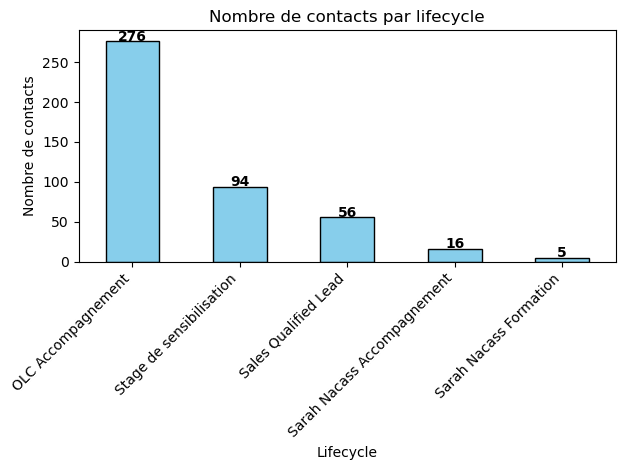

In [9]:
import matplotlib.pyplot as plt

counts = df["lifecycle_name"].value_counts()

ax = counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Nombre de contacts par lifecycle")
plt.xlabel("Lifecycle")
plt.ylabel("Nombre de contacts")

# Affichage du nombre sur chaque barre
for i, v in enumerate(counts):
    ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Axes: >

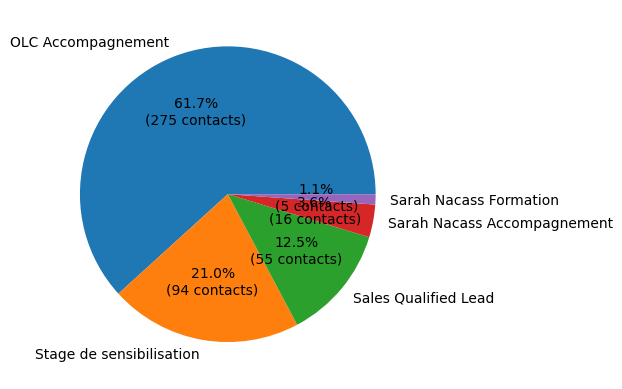

In [10]:
counts.plot(kind="pie", 
            autopct=lambda p: f"{p:.1f}%\n({int(p * counts.sum() / 100)} contacts)",
            ylabel='')




In [11]:
import pandas as pd

df = pd.read_csv('contacts_annee_2025.csv', dtype={'mobile_number': str, 'work_number': str})

df = df.replace(['NaN', 'Nan'], '')
df = df.fillna('')

email_column = 'email'

df[email_column] = df[email_column].str.strip().str.lower()

duplicated_emails = df[df.duplicated(email_column, keep=False) & (df[email_column] != '')]

duplicated_emails = duplicated_emails.sort_values(by=email_column)

total_doublons = len(duplicated_emails)
nb_emails_dupliques = duplicated_emails[email_column].nunique()

print(f"Nombre total de lignes avec des doublons : {total_doublons}")
print(f"Nombre d'e-mails uniques dupliqués : {nb_emails_dupliques}")

duplicated_emails.to_csv('contacts_rs_doublon.csv', index=False, encoding='utf-8')
duplicated_emails

Nombre total de lignes avec des doublons : 0
Nombre d'e-mails uniques dupliqués : 0


,id,first_name,last_name,email,work_number,mobile_number,phone_number,cf_id_bitrix,cf_action_initiale_du_prospect,cf_date_de_creation,...,status_name,lifecycle_id,lifecycle_name,deal_name,deal_amount,deal_stage,deal_pipeline,deal_lifecycle,deal_owner,notes


In [12]:
import pandas as pd

df = pd.read_csv('contacts_rs_doublon.csv', dtype=str)

df = df.rename(columns={
    'cf_budget_journalier_utm_medium': 'cf_budget_journalier',
    'cf_ciblage_utm_term': 'cf_ciblage',
    'cf_message_publicitaire_utm_content': 'cf_message_publicitaire',
    'cf_nom_de_la_campagne_de_publicit_utm_campaign': 'cf_nom_de_la_campagne_publicitaire',
})

print("Colonnes détectées :", df.columns.tolist())

df = df.replace(['NaN', 'Nan'], '')
df = df.fillna('')
df['email'] = df['email'].str.strip().str.lower()

duplicated_emails = df[df.duplicated('email', keep=False) & (df['email'] != '')]

def concat_with_plus_sorted(values):
    non_empty = [str(v).strip() for v in values if pd.notna(v) and str(v).strip()]
    return ' + '.join(sorted(set(non_empty))) if non_empty else ''

def concat_dates_desc_sorted(values):
    dates = [str(v).strip() for v in values if pd.notna(v) and str(v).strip()]
    try:
        dates = sorted(set(dates), key=lambda x: pd.to_datetime(x, errors='coerce'), reverse=True)
    except Exception:
        dates = sorted(set(dates), reverse=True)
    return ' + '.join(dates) if dates else ''

def concat_unique_mobile(values):
    unique = sorted(set(str(v).strip() for v in values if pd.notna(v) and str(v).strip()))
    return ' / '.join(unique) if unique else ''

def get_first_non_empty(values):
    for v in values:
        v_str = str(v).strip()
        if pd.notna(v) and v_str:
            return v_str
    return ''

columns_to_aggregate = {
    'first_name': get_first_non_empty,
    'last_name': get_first_non_empty,
    'mobile_number': get_first_non_empty,
    'work_number': concat_unique_mobile,
    'phone_number': concat_unique_mobile,
    'email': get_first_non_empty,
    'cf_action_initiale_du_prospect': concat_with_plus_sorted,
    'cf_date_de_creation': concat_dates_desc_sorted,
    'notes': concat_with_plus_sorted,
    'cf_id_bitrix': get_first_non_empty,
    'deal_name': concat_with_plus_sorted,
    'deal_amount': concat_with_plus_sorted,
    'deal_stage': concat_with_plus_sorted,
    'deal_pipeline': concat_with_plus_sorted,
    'deal_lifecycle': concat_with_plus_sorted,
    'deal_owner': concat_with_plus_sorted,
    'status_name': get_first_non_empty,
    'lifecycle_name': get_first_non_empty,
}


if 'cf_note1' in df.columns:
    columns_to_aggregate['cf_note1'] = concat_with_plus_sorted
if 'cf_note2' in df.columns:
    columns_to_aggregate['cf_note2'] = concat_with_plus_sorted


grouped = (
    duplicated_emails
    .groupby('email', as_index=False)
    .agg(columns_to_aggregate)
)

grouped['fusion_note'] = 'principale'
fusionnees = duplicated_emails.copy()
fusionnees['fusion_note'] = 'doublon'

colonnes = list(grouped.columns)
final_df = pd.concat([grouped, fusionnees[colonnes]], ignore_index=True)
final_df = final_df.sort_values(by='email')

final_df.to_csv('contacts_fusionnes.csv', index=False, encoding='utf-8')
print("\nExport terminé : contacts_fusionnes.csv")

final_df

Colonnes détectées : ['id', 'first_name', 'last_name', 'email', 'work_number', 'mobile_number', 'phone_number', 'cf_id_bitrix', 'cf_action_initiale_du_prospect', 'cf_date_de_creation', 'cf_budget_journalier', 'cf_ciblage', 'cf_inscription_utm_source', 'cf_message_publicitaire', 'cf_nom_de_la_campagne_publicitaire', 'cf_note1', 'cf_note2', 'created_at', 'status_id', 'status_name', 'lifecycle_id', 'lifecycle_name', 'deal_name', 'deal_amount', 'deal_stage', 'deal_pipeline', 'deal_lifecycle', 'deal_owner', 'notes']

Export terminé : contacts_fusionnes.csv


,first_name,last_name,mobile_number,work_number,phone_number,email,cf_action_initiale_du_prospect,cf_date_de_creation,notes,cf_id_bitrix,...,deal_amount,deal_stage,deal_pipeline,deal_lifecycle,deal_owner,status_name,lifecycle_name,cf_note1,cf_note2,fusion_note


In [13]:
import pandas as pd

df = pd.read_csv('contacts_fusionnes.csv', dtype=str)
df = df.fillna('')

colonnes_a_inverser = [
    'cf_date_de_creation',
    'cf_action_initiale_du_prospect',
    'notes',
    'deal_name',
    'deal_amount',
    'deal_stage',
    'deal_pipeline',
    'deal_lifecycle',
    'deal_owner',
    'cf_note1',
    'cf_note2',
]

colonnes_a_inverser = [col for col in colonnes_a_inverser if col in df.columns]

def inverser_blocs(valeur):
    if isinstance(valeur, str) and " + " in valeur:
        blocs = [v.strip() for v in valeur.split(" + ") if v.strip()]
        return " + ".join(blocs[::-1])
    return valeur.strip() if isinstance(valeur, str) else valeur

for col in colonnes_a_inverser:
    df[col] = df[col].apply(inverser_blocs)

df.to_csv('contacts_fusionnes_inverses.csv', index=False, encoding='utf-8')
print("Fichier exporté : contacts_fusionnes_inverses.csv")
df

Fichier exporté : contacts_fusionnes_inverses.csv


,first_name,last_name,mobile_number,work_number,phone_number,email,cf_action_initiale_du_prospect,cf_date_de_creation,notes,cf_id_bitrix,...,deal_amount,deal_stage,deal_pipeline,deal_lifecycle,deal_owner,status_name,lifecycle_name,cf_note1,cf_note2,fusion_note


<span style="color: black; font-weight: bold; font-size: 50px;">Filtrage de la valeur fusionne de la colonne fusion_note</span>

In [14]:
import pandas as pd

df = pd.read_csv('contacts_fusionnes.csv')

doublon = df[df['fusion_note'].str.lower() == 'doublon']

doublon = doublon.replace(['Nan', 'NaN'], '')
doublon = doublon.fillna('')

doublon.to_csv('contacts_fusionnes_doublons.csv', index=False, encoding='utf-8')

doublon

,first_name,last_name,mobile_number,work_number,phone_number,email,cf_action_initiale_du_prospect,cf_date_de_creation,notes,cf_id_bitrix,...,deal_amount,deal_stage,deal_pipeline,deal_lifecycle,deal_owner,status_name,lifecycle_name,cf_note1,cf_note2,fusion_note


<span style="color: black; font-weight: bold; font-size: 50px;">Suppression des doublons</span>

In [ ]:
import csv
import requests
import time

BATCH_SIZE = 990
SLEEP_TIME = 3600  
API_KEY_FRESHWORK = ''
DOMAIN_FRESHWORK = ''
BASE_URL = f'https://{DOMAIN_FRESHWORK}.myfreshworks.com/crm/sales/'

def get_existing_contacts(api_key, domain):
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Token token={api_key}'
    }
    endpoint = "contacts/view/31004512042"
    url = f"{BASE_URL}{endpoint}"
    all_contacts = {}
    page = 1

    while True:
        print(f"Récupération de la page {page} des contacts...")
        params = {'per_page': 100, 'page': page}
        response = requests.get(url, headers=headers, params=params)

        if not response.ok:
            print(f"Erreur récupération des contacts : {response.status_code}")
            break

        contacts_data = response.json().get('contacts', [])
        for contact in contacts_data:
            bitrix_id = contact.get('custom_field', {}).get('cf_id_bitrix', '')
            if bitrix_id:
                all_contacts[bitrix_id] = contact

        if len(contacts_data) < 100:
            break

        page += 1
        time.sleep(1)

    print(f"{len(all_contacts)} contacts existants récupérés depuis Freshsales.")
    return all_contacts

def delete_contact(api_key, domain, contact_id):
    url = f"{BASE_URL}api/contacts/{contact_id}"
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Token token={api_key}'
    }

    try:
        response = requests.delete(url, headers=headers, timeout=30)
        if response.status_code == 200:
            print(f"Contact supprimé : ID {contact_id}")
        else:
            print(f"Erreur suppression contact {contact_id} : {response.status_code}")
            print(f"Réponse : {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"Erreur réseau lors de la suppression du contact {contact_id} : {e}")

def main():
    try:
        with open('contacts_fusionnes_doublons.csv', 'r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            bitrix_contacts = list(reader)
    except Exception as e:
        print("Fichier introuvable ou erreur de lecture.")
        print(e)
        return

    if not bitrix_contacts:
        print("Aucun contact dans le fichier CSV.")
        return

    existing_contacts = get_existing_contacts(API_KEY_FRESHWORK, DOMAIN_FRESHWORK)

    total_contacts = len(bitrix_contacts)
    deleted_count = 0
    batches = [bitrix_contacts[i:i + BATCH_SIZE] for i in range(0, total_contacts, BATCH_SIZE)]

    for batch_index, batch in enumerate(batches, start=1):
        print(f"Traitement du lot {batch_index}/{len(batches)}")

        for contact_csv in batch:
            bitrix_id = contact_csv.get("cf_id_bitrix", "")
            if bitrix_id in existing_contacts:
                contact_id = existing_contacts[bitrix_id]['id']
                delete_contact(API_KEY_FRESHWORK, DOMAIN_FRESHWORK, contact_id)
                deleted_count += 1
            else:
                print(f"Contact non trouvé dans Freshsales : Bitrix ID {bitrix_id}")

        if batch_index < len(batches):
            print(f"Pause de {SLEEP_TIME} secondes avant le prochain lot...")
            time.sleep(SLEEP_TIME)

    print(f"Suppression terminée : {deleted_count} contact(s) supprimé(s).")

if __name__ == "__main__":
    main()


<span style="color: black; font-weight: bold; font-size: 50px;">Filtrage de la valeur principale(doublon regrouper en 1) de la colonne fusion_note</span>

In [15]:
import pandas as pd

df = pd.read_csv('contacts_fusionnes_inverses.csv', dtype={'mobile_number': str})

principaux = df[df['fusion_note'].str.lower() == 'principale']

principaux = principaux.replace(['Nan', 'NaN'], '')
principaux = principaux.fillna('')

principaux.to_csv('contacts_fusionnes_principaux.csv', index=False, encoding='utf-8')


principaux

,first_name,last_name,mobile_number,work_number,phone_number,email,cf_action_initiale_du_prospect,cf_date_de_creation,notes,cf_id_bitrix,...,deal_amount,deal_stage,deal_pipeline,deal_lifecycle,deal_owner,status_name,lifecycle_name,cf_note1,cf_note2,fusion_note


<span style="color: black; font-weight: bold; font-size: 50px;">Création du doublon regrouper en 1</span>

In [ ]:
import csv
import json
import time
import requests

API_KEY = ''
DOMAIN = ''
BASE_URL = f'https://{DOMAIN}.myfreshworks.com/crm/sales/'
HEADERS = {
    'Content-Type': 'application/json',
    'Authorization': f'Token token={API_KEY}'
}


def safe_get(url, params=None):
    while True:
        response = requests.get(url, headers=HEADERS, params=params)
        if response.status_code == 429:
            print("Rate limit atteint (429). Pause 5 min...")
            time.sleep(300)
            continue
        return response


def get_pipelines():
    url = f"{BASE_URL}api/selector/deal_pipelines"
    response = safe_get(url)
    return {p["id"]: p["name"] for p in response.json().get("deal_pipelines", [])} if response.status_code == 200 else {}


def get_pipeline_stages(pipeline_id):
    url = f"{BASE_URL}api/selector/deal_pipelines/{pipeline_id}/deal_stages"
    response = safe_get(url)
    return {s["id"]: s["name"] for s in response.json().get("deal_stages", [])} if response.status_code == 200 else {}


def get_deal_metadata():
    pipelines = get_pipelines()
    deal_stages = {}
    for pid in pipelines:
        deal_stages.update(get_pipeline_stages(pid))
    return pipelines, deal_stages


def load_mappings_from_json(filepath="freshworks_statuses.json"):
    try:
        with open(filepath, "r", encoding="utf-8") as file:
            data = json.load(file)
    except Exception as e:
        print(f"Erreur chargement fichier JSON : {e}")
        return {}, {}

    lifecycle_stage_map = {}
    status_name_to_id = {}

    for stage in data.get("lifecycle_stages", []):
        lifecycle_stage_map[stage["name"]] = stage["id"]

    for status in data.get("contact_statuses", []):
        status_name_to_id[status["name"]] = status["id"]

    return lifecycle_stage_map, status_name_to_id


def extract_contact_info(row, lifecycle_stage_map, status_name_to_id):
    def truncate(value, max_length):
        return value[:max_length] if isinstance(value, str) else value

    contact_data = {
        "first_name": row.get("first_name", "").strip(),
        "last_name": row.get("last_name", "").strip(),
        "email": row.get("email", "").strip().lower(),
        "mobile_number": row.get("mobile_number", "").strip(),
        "custom_field": {
            "cf_id_bitrix": row.get("cf_id_bitrix", "").strip(),
            "cf_action_initiale_du_prospect": truncate(row.get("cf_action_initiale_du_prospect", ""), 255),
            "cf_objectif_formul": row.get("cf_objectif_formul", ""),
            "cf_date_de_creation": row.get("cf_date_de_creation", ""),
            "cf_budget_journalier_utm_medium": row.get("cf_budget_journalier", ""),
            "cf_nom_de_la_campagne_de_publicit_utm_campaign": row.get("cf_nom_de_la_campagne_publicitaire", ""),
            "cf_ciblage_utm_term": row.get("cf_ciblage", ""),
            "cf_inscription_utm_source": row.get("cf_inscription_utm_source", ""),
            "cf_message_publicitaire_utm_content": row.get("cf_message_publicitaire", ""),
            "cf_note1": row.get("cf_note1", ""),
            "cf_note2": row.get("cf_note2", ""),
        }
    }

    lifecycle_name = row.get("lifecycle_name", "").strip()
    lifecycle_id = lifecycle_stage_map.get(lifecycle_name)
    if lifecycle_id:
        contact_data["lifecycle_stage_id"] = lifecycle_id
    else:
        print(f"Étape de cycle de vie inconnue : '{lifecycle_name}'")

    status_name = row.get("status_name", "").strip()
    status_id = status_name_to_id.get(status_name)
    if status_id:
        contact_data["contact_status_id"] = status_id
    else:
        print(f"Statut inconnu : '{status_name}'")

    return contact_data


def create_contact(contact_data):
    url = f"{BASE_URL}api/contacts"
    try:
        response = requests.post(url, headers=HEADERS, json={'contact': contact_data}, timeout=30)
        if response.status_code in [200, 201]:
            contact_id = response.json()["contact"]["id"]
            print(f"Contact créé : {contact_data.get('email', contact_data.get('mobile_number'))} (ID: {contact_id})")
            return contact_id
        else:
            print(f"Erreur création contact : {response.status_code} | {response.text}")
    except Exception as e:
        print(f"Exception lors de la création du contact : {e}")
    return None


def add_note_to_contact(contact_id, note_text):
    if not note_text.strip():
        return

    url = f"{BASE_URL}api/notes"
    payload = {
        "note": {
            "description": note_text,
            "creater_id": 31000890026,
            "targetables": [{"id": contact_id, "type": "Contact"}],
            "user": {
                "id": 31000890026,
                "display_name": "James Aurelie",
                "email": "accueil@sarahnacass.com"
            }
        }
    }

    response = requests.post(url, headers=HEADERS, json=payload)
    if response.status_code == 201:
        print(f"Note ajoutée au contact ID {contact_id}")
    else:
        print(f"Erreur ajout note (ID {contact_id}) : {response.status_code} | {response.text}")


def create_deal_from_csv(contact_id, row, pipelines, deal_stages):
    contact_name = f"{row.get('first_name', '')} {row.get('last_name', '')}".strip()

    try:
        amount = float(str(row.get("deal_amount", "0")).replace(",", ".").replace("€", "").strip())
    except ValueError:
        print(f"Montant invalide pour {contact_name}, mis à 0")
        amount = 0.0

    pipeline_name = row.get("deal_pipeline", "").strip()
    stage_name = row.get("deal_stage", "").strip()
    deal_name = row.get("deal_name", f"Affaire de {contact_name}")

    pipeline_id = next((pid for pid, name in pipelines.items() if name == pipeline_name), None)
    stage_id = next((sid for sid, name in deal_stages.items() if name == stage_name), None)

    if not pipeline_id or not stage_id:
        print(f"Pipeline/stage non trouvé pour {contact_name} ({pipeline_name} / {stage_name})")
        return

    payload = {
        "deal": {
            "name": deal_name,
            "deal_pipeline_id": pipeline_id,
            "deal_stage_id": stage_id,
            "amount": amount,
            "contacts_added_list": [contact_id]
        }
    }

    url = f"{BASE_URL}api/deals"
    response = requests.post(url, headers=HEADERS, json=payload)
    if response.status_code in [200, 201]:
        print(f"Deal créé pour {contact_name} : {deal_name}")
    else:
        print(f"Erreur création deal pour {contact_name} : {response.status_code} | {response.text}")


def main():
    print("Démarrage du script de création de contacts + deals + notes...")

    pipelines, deal_stages = get_deal_metadata()
    lifecycle_stage_map, status_name_to_id = load_mappings_from_json("freshworks_statuses.json")

    try:
        with open("contacts_fusionnes_principaux.csv", "r", encoding="utf-8") as file:
            reader = csv.DictReader(file)
            rows = list(reader)
    except Exception as e:
        print(f"Fichier introuvable ou illisible : {e}")
        return

    for index, row in enumerate(rows, start=1):
        print(f"\nTraitement contact {index}/{len(rows)} : {row.get('email', row.get('mobile_number', 'sans email'))}")

        contact_info = extract_contact_info(row, lifecycle_stage_map, status_name_to_id)
        contact_id = create_contact(contact_info)

        if contact_id:
            note_text = row.get("notes", "").strip()
            if note_text:
                add_note_to_contact(contact_id, note_text)
            create_deal_from_csv(contact_id, row, pipelines, deal_stages)
        else:
            print("Contact non créé, deal et note non traités.")

        time.sleep(2)

    print("\nTous les contacts, deals et notes ont été traités.")


if __name__ == "__main__":
    main()


In [1]:
import gspread
import csv
from datetime import datetime
import gspread
from gspread_formatting import format_cell_range, CellFormat, TextFormat, Color

gc = gspread.service_account(filename="anomalieV2.json")

sh = gc.open_by_key('1cMEvZRMf8HWIeWIuZfGCojR4oMzPaJFGjnIEb4_4q8g')
worksheet = sh.worksheet("Anomalies traiter")
worksheet.clear()

with open("contacts_fusionnes_inverses.csv", 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    rows = list(reader)

worksheet.update(values=rows, range_name='A1')

now = datetime.now()
date_string = now.strftime("%d/%m/%Y à %H:%M:%S")
worksheet.update_acell('V2', date_string)

blue_text = CellFormat(
    textFormat=TextFormat(fontSize=10, bold=True, foregroundColor=Color(0, 0, 1))
)
red_text = CellFormat(
    textFormat=TextFormat(fontSize=10, foregroundColor=Color(1, 0, 0))
)
header_format = CellFormat(
    textFormat=TextFormat(bold=True, fontSize=11)
)

last_col_letter = chr(64 + len(rows[0])) if len(rows[0]) <= 26 else 'Z'
format_cell_range(worksheet, f"A1:{last_col_letter}1", header_format)

header = rows[0]
if "fusion_note" not in header:
    raise ValueError("La colonne 'fusion_note' est introuvable dans le fichier CSV.")
fusion_note_index = header.index("fusion_note")

for idx, row in enumerate(rows[1:], start=2): 
    if len(row) > fusion_note_index:
        value = row[fusion_note_index].strip().lower()
        last_col_letter = chr(64 + len(row)) if len(row) <= 26 else 'Z'
        range_str = f"A{idx}:{last_col_letter}{idx}"

        if value == "principale":
            format_cell_range(worksheet, range_str, blue_text)
        elif value == "doublon":
            format_cell_range(worksheet, range_str, red_text)

worksheet = None


<span style="color: black; font-weight: bold; font-size: 50px;">Traitement des doublons Mobile</span>

In [ ]:
import requests
import pandas as pd
import time
from datetime import datetime
from dateutil import parser as date_parser
import pytz

API_KEY = ""
DOMAIN = ""
VIEW_ID = ""
BASE_URL = f"https://{DOMAIN}.myfreshworks.com/crm/sales/"
HEADERS = {
    "Content-Type": "application/json",
    "Authorization": f"Token token={API_KEY}"
}
LOCAL_TZ = pytz.timezone("Europe/Paris")

def safe_get(url, params=None):
    while True:
        response = requests.get(url, headers=HEADERS, params=params)
        if response.status_code == 429:
            print("Rate limit (429). Pause 5 minutes...")
            time.sleep(300)
            continue
        return response

def fetch_data(endpoint):
    url = f"{BASE_URL}api/selector/{endpoint}"
    response = safe_get(url)
    if response.status_code == 200:
        return {item["id"]: item["name"] for item in response.json().get(endpoint, [])}
    return {}

def get_contact_statuses():
    url = f"{BASE_URL}api/selector/contact_statuses"
    response = safe_get(url)
    if response.status_code == 200:
        return response.json().get("contact_statuses", [])
    return []

def build_status_mappings():
    statuses = get_contact_statuses()
    status_id_to_name = {}
    status_id_to_lifecycle_id = {}

    lifecycle_id_to_name = {
        32012758207: "Sarah Nacass Accompagnement",
        32019529362: "Sarah Nacass Formation",
        32022743043: "Stage de sensibilisation",
        32023906873: "OLC Accompagnement",
        32012758208: "Sales Qualified Lead",
        32012758209: "Fermé - Gagné/Perdu"
    }

    for status in statuses:
        sid = status.get("id")
        status_id_to_name[sid] = status.get("name")
        status_id_to_lifecycle_id[sid] = status.get("lifecycle_stage_id")

    return status_id_to_name, status_id_to_lifecycle_id, lifecycle_id_to_name

def get_deal_metadata():
    pipelines = fetch_data("deal_pipelines")
    deal_stages = {}
    for pid in pipelines:
        url = f"{BASE_URL}api/selector/deal_pipelines/{pid}/deal_stages"
        resp = safe_get(url)
        if resp.status_code == 200:
            stages = resp.json().get("deal_stages", [])
            deal_stages.update({s["id"]: s["name"] for s in stages})
    lifecycle_stages = fetch_data("lifecycle_stages")
    owners = fetch_data("owners")
    return pipelines, deal_stages, lifecycle_stages, owners

def get_contact_notes(contact_id):
    url = f"{BASE_URL}api/contacts/{contact_id}/notes"
    response = safe_get(url, params={'per_page': 5, 'sort': 'created_at.desc'})
    if response.status_code != 200:
        return ""
    notes = response.json().get("notes", [])
    return " || ".join(n.get("description", "") for n in notes if n.get("description"))

def get_contact_deals(contact_id, pipelines, deal_stages, lifecycle_stages, owners):
    url = f"{BASE_URL}api/contacts/{contact_id}/deals"
    response = safe_get(url)
    if response.status_code != 200:
        return []

    deals = response.json().get("deals", [])
    enriched = []
    for deal in deals:
        enriched.append({
            "name": deal.get("name", ""),
            "amount": deal.get("amount", ""),
            "stage_name": deal_stages.get(deal.get("deal_stage_id", ""), "Inconnu"),
            "pipeline_name": pipelines.get(deal.get("deal_pipeline_id", ""), "Inconnu"),
            "lifecycle_name": lifecycle_stages.get(deal.get("lifecycle_stage_id", ""), "Inconnu"),
            "owner_name": owners.get(deal.get("owner_id", ""), "Inconnu"),
        })
    return enriched

def get_contacts_for_year_2025(status_id_to_name, lifecycle_id_to_name):
    year_start = datetime(2025, 1, 1, tzinfo=LOCAL_TZ).date()
    year_end = datetime(2025, 12, 31, tzinfo=LOCAL_TZ).date()

    all_contacts = []
    page = 1
    pipelines, deal_stages, lifecycle_stages, owners = get_deal_metadata()

    while True:
        print(f"Page {page}...")
        url = f"{BASE_URL}api/contacts/view/{VIEW_ID}"
        params = {'per_page': 100, 'page': page}
        response = safe_get(url, params)

        if response.status_code != 200:
            print(f"Erreur page {page} : {response.status_code}")
            break

        contacts = response.json().get("contacts", [])
        if not contacts:
            break

        for c in contacts:
            created_at_str = c.get("created_at")
            if not created_at_str:
                continue

            created_at = date_parser.isoparse(created_at_str).astimezone(LOCAL_TZ)
            created_date = created_at.date()

            if not (year_start <= created_date <= year_end):
                print(f"Ignoré : {created_date}")
                continue

            contact_id = c.get("id")
            detail_url = f"{BASE_URL}api/contacts/{contact_id}?include=contact_status,lifecycle_stage"
            detail_resp = safe_get(detail_url)
            if detail_resp.status_code != 200:
                continue

            detailed = detail_resp.json().get("contact", {})
            custom = detailed.get("custom_field", {})

            email = detailed.get("email", "")
            first_name = detailed.get("first_name", "")
            last_name = detailed.get("last_name", "")
            status_id = detailed.get("contact_status_id")
            lifecycle_id = detailed.get("lifecycle_stage_id")
            status_name = status_id_to_name.get(status_id, "Inconnu")
            lifecycle_name = lifecycle_id_to_name.get(lifecycle_id, "Inconnu")

            deals = get_contact_deals(contact_id, pipelines, deal_stages, lifecycle_stages, owners)
            first_deal = deals[0] if deals else {}

            print(f"{created_date} | {first_name} {last_name}")

            all_contacts.append({
                "id": contact_id,
                "first_name": first_name,
                "last_name": last_name,
                "email": email,
                "work_number": detailed.get("work_number", ""),
                "mobile_number": detailed.get("mobile_number", ""),
                "phone_number": custom.get("cf_nom_du_prospect", ""),
                "cf_id_bitrix": custom.get("cf_id_bitrix", ""),
                "cf_action_initiale_du_prospect": custom.get("cf_action_initiale_du_prospect", ""),
                "cf_date_de_creation": custom.get("cf_date_de_creation", ""),
                "cf_budget_journalier": custom.get("cf_budget_journalier_utm_medium", ""),
                "cf_ciblage": custom.get("cf_ciblage_utm_term", ""),
                "cf_inscription_utm_source": custom.get("cf_inscription_utm_source", ""),
                "cf_message_publicitaire": custom.get("cf_message_publicitaire_utm_content", ""),
                "cf_nom_de_la_campagne_publicitaire": custom.get("cf_nom_de_la_campagne_de_publicit_utm_campaign", ""),
                "cf_note1": custom.get("cf_note1", ""),
                "cf_note2": custom.get("cf_note2", ""),
                "created_at": created_at_str,
                "status_id": status_id,
                "status_name": status_name,
                "lifecycle_id": lifecycle_id,
                "lifecycle_name": lifecycle_name,
                "deal_name": first_deal.get("name", ""),
                "deal_amount": first_deal.get("amount", ""),
                "deal_stage": first_deal.get("stage_name", ""),
                "deal_pipeline": first_deal.get("pipeline_name", ""),
                "deal_lifecycle": first_deal.get("lifecycle_name", ""),
                "deal_owner": first_deal.get("owner_name", ""),
                "notes": get_contact_notes(contact_id)
            })

            time.sleep(0.4)

        page += 1
        time.sleep(1)

    print(f"Total : {len(all_contacts)} contacts de l’année 2025 récupérés.")
    return all_contacts

def main():
    print("Démarrage - Récupération des contacts de l'année 2025...")
    status_id_to_name, _, lifecycle_id_to_name = build_status_mappings()
    contacts = get_contacts_for_year_2025(status_id_to_name, lifecycle_id_to_name)

    if not contacts:
        print("Aucun contact trouvé pour l'année 2025.")
        df = pd.DataFrame(columns=[
            "id", "first_name", "last_name", "email", "work_number", "mobile_number", "phone_number",
            "cf_id_bitrix", "cf_action_initiale_du_prospect", "cf_date_de_creation", 'cf_budget_journalier',
            'cf_ciblage', 'cf_inscription_utm_source', 'cf_message_publicitaire',
            'cf_nom_de_la_campagne_publicitaire', "cf_note1", "cf_note2", "created_at",
            "status_id", "status_name", "lifecycle_id", "lifecycle_name",
            "deal_name", "deal_amount", "deal_stage", "deal_pipeline", "deal_lifecycle", "deal_owner", "notes"
        ])
    else:
        df = pd.DataFrame(contacts)

    df.to_csv("contacts_annee_2025_mobile.csv", index=False, encoding="utf-8")
    print("Export terminé : contacts_annee_2025_mobile.csv")

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import requests
import pandas as pd
import time
from datetime import datetime
from dateutil import parser as date_parser
import pytz
df = pd.read_csv('contacts_annee_2025_mobile.csv', encoding='utf-8', dtype={'mobile_number': str, 'work_number': str})
df 

In [12]:
import pandas as pd

df = pd.read_csv('contacts_annee_2025_mobile.csv', dtype={'mobile_number': str, 'work_number': str})

df = df.replace(['NaN', 'Nan'], '')
df = df.fillna('')

mobile_column = 'mobile_number'

df[mobile_column] = df[mobile_column].str.strip().str.lower()

duplicated_mobile = df[df.duplicated(mobile_column, keep=False) & (df[mobile_column] != '')]

duplicated_mobile = duplicated_mobile.sort_values(by=mobile_column)

total_doublons = len(duplicated_mobile)
nb_mobile_dupliques = duplicated_mobile[mobile_column].nunique()

print(f"Nombre total de lignes avec des doublons : {total_doublons}")
print(f"Nombre d'mobile uniques dupliqués : {nb_mobile_dupliques}")

duplicated_mobile.to_csv('contacts_rs_doublon_mobile.csv', index=False, encoding='utf-8')
duplicated_mobile

Nombre total de lignes avec des doublons : 0
Nombre d'mobile uniques dupliqués : 0


,id,first_name,last_name,email,work_number,mobile_number,phone_number,cf_id_bitrix,cf_action_initiale_du_prospect,cf_date_de_creation,...,status_name,lifecycle_id,lifecycle_name,deal_name,deal_amount,deal_stage,deal_pipeline,deal_lifecycle,deal_owner,notes


In [13]:
import pandas as pd

df = pd.read_csv('contacts_rs_doublon_mobile.csv', dtype=str)

df = df.rename(columns={
    'cf_budget_journalier_utm_medium': 'cf_budget_journalier',
    'cf_ciblage_utm_term': 'cf_ciblage',
    'cf_message_publicitaire_utm_content': 'cf_message_publicitaire',
    'cf_nom_de_la_campagne_de_publicit_utm_campaign': 'cf_nom_de_la_campagne_publicitaire',
    'id': 'id'
})

print("Colonnes détectées :", df.columns.tolist())

df = df.replace(['NaN', 'Nan'], '')
df = df.fillna('')
df['mobile_number'] = df['mobile_number'].str.strip()

duplicated_mobiles = df[df.duplicated('mobile_number', keep=False) & (df['mobile_number'] != '')]

def concat_with_plus_sorted(values):
    non_empty = [str(v).strip() for v in values if pd.notna(v) and str(v).strip()]
    return ' + '.join(sorted(set(non_empty))) if non_empty else ''

def concat_dates_desc_sorted(values):
    dates = [str(v).strip() for v in values if pd.notna(v) and str(v).strip()]
    try:
        dates = sorted(set(dates), key=lambda x: pd.to_datetime(x, errors='coerce'), reverse=True)
    except Exception:
        dates = sorted(set(dates), reverse=True)
    return ' + '.join(dates) if dates else ''

def concat_unique_mobile(values):
    unique = sorted(set(str(v).strip() for v in values if pd.notna(v) and str(v).strip()))
    return ' / '.join(unique) if unique else ''

def get_first_non_empty(values):
    for v in values:
        v_str = str(v).strip()
        if pd.notna(v) and v_str:
            return v_str
    return ''

columns_to_aggregate = {
    'first_name': get_first_non_empty,
    'last_name': get_first_non_empty,
    'mobile_number': get_first_non_empty,
    'work_number': concat_unique_mobile,
    'phone_number': concat_unique_mobile,
    'email': get_first_non_empty,
    'cf_action_initiale_du_prospect': concat_with_plus_sorted,
    'cf_date_de_creation': concat_dates_desc_sorted,
    'notes': concat_with_plus_sorted,
    'cf_id_bitrix': get_first_non_empty,
    'deal_name': concat_with_plus_sorted,
    'deal_amount': concat_with_plus_sorted,
    'deal_stage': concat_with_plus_sorted,
    'deal_pipeline': concat_with_plus_sorted,
    'deal_lifecycle': concat_with_plus_sorted,
    'deal_owner': concat_with_plus_sorted,
    'status_name': get_first_non_empty,
    'lifecycle_name': get_first_non_empty,
    'id': get_first_non_empty  

}

if 'cf_note1' in df.columns:
    columns_to_aggregate['cf_note1'] = concat_with_plus_sorted
if 'cf_note2' in df.columns:
    columns_to_aggregate['cf_note2'] = concat_with_plus_sorted

grouped = (
    duplicated_mobiles
    .groupby('mobile_number', as_index=False)
    .agg(columns_to_aggregate)
)

grouped['fusion_note'] = 'principale'
fusionnees = duplicated_mobiles.copy()
fusionnees['fusion_note'] = 'doublon'

colonnes = list(grouped.columns)
final_df = pd.concat([grouped, fusionnees[colonnes]], ignore_index=True)
final_df = final_df.sort_values(by='mobile_number')

final_df.to_csv('contacts_fusionnes_mobile.csv', index=False, encoding='utf-8')
print("\nExport terminé : contacts_fusionnes.csv")

final_df


Colonnes détectées : ['id', 'first_name', 'last_name', 'email', 'work_number', 'mobile_number', 'phone_number', 'cf_id_bitrix', 'cf_action_initiale_du_prospect', 'cf_date_de_creation', 'cf_budget_journalier', 'cf_ciblage', 'cf_inscription_utm_source', 'cf_message_publicitaire', 'cf_nom_de_la_campagne_publicitaire', 'cf_note1', 'cf_note2', 'created_at', 'status_id', 'status_name', 'lifecycle_id', 'lifecycle_name', 'deal_name', 'deal_amount', 'deal_stage', 'deal_pipeline', 'deal_lifecycle', 'deal_owner', 'notes']

Export terminé : contacts_fusionnes.csv


,first_name,last_name,mobile_number,work_number,phone_number,email,cf_action_initiale_du_prospect,cf_date_de_creation,notes,cf_id_bitrix,...,deal_stage,deal_pipeline,deal_lifecycle,deal_owner,status_name,lifecycle_name,id,cf_note1,cf_note2,fusion_note


In [14]:
import pandas as pd


df = pd.read_csv('contacts_fusionnes_mobile.csv', dtype=str)
df = df.fillna('')

colonnes_a_inverser = [
    'cf_date_de_creation',
    'cf_action_initiale_du_prospect',
    'notes',
    'deal_name',
    'deal_amount',
    'deal_stage',
    'deal_pipeline',
    'deal_lifecycle',
    'deal_owner',
    'cf_note1',
    'cf_note2',
]

colonnes_a_inverser = [col for col in colonnes_a_inverser if col in df.columns]

def inverser_blocs(valeur):
    if isinstance(valeur, str) and " + " in valeur:
        blocs = [v.strip() for v in valeur.split(" + ") if v.strip()]
        return " + ".join(blocs[::-1])
    return valeur.strip() if isinstance(valeur, str) else valeur

for col in colonnes_a_inverser:
    df[col] = df[col].apply(inverser_blocs)

df.to_csv('contacts_fusionnes_mobile_inverses.csv', index=False, encoding='utf-8')
print("Fichier exporté : contacts_fusionnes_inverses.csv")
df

Fichier exporté : contacts_fusionnes_inverses.csv


,first_name,last_name,mobile_number,work_number,phone_number,email,cf_action_initiale_du_prospect,cf_date_de_creation,notes,cf_id_bitrix,...,deal_stage,deal_pipeline,deal_lifecycle,deal_owner,status_name,lifecycle_name,id,cf_note1,cf_note2,fusion_note


<span style="color: black; font-weight: bold; font-size: 50px;">Filtrage de la valeur fusionne de la colonne fusion_note</span>

In [16]:
import pandas as pd

df = pd.read_csv('contacts_fusionnes_mobile_inverses.csv', dtype=str)

doublon = df[df['fusion_note'].str.lower() == 'doublon']

doublon = doublon.replace(['Nan', 'NaN'], '')
doublon = doublon.fillna('')

doublon.to_csv('contacts_fusionnes_doublons_mobile.csv', index=False, encoding='utf-8')

doublon

,first_name,last_name,mobile_number,work_number,phone_number,email,cf_action_initiale_du_prospect,cf_date_de_creation,notes,cf_id_bitrix,...,deal_stage,deal_pipeline,deal_lifecycle,deal_owner,status_name,lifecycle_name,id,cf_note1,cf_note2,fusion_note


<span style="color: black; font-weight: bold; font-size: 50px;">Suppression des doublons</span>

In [ ]:
import csv
import requests
import time

BATCH_SIZE = 990
SLEEP_TIME = 3600
API_KEY_FRESHWORK = ''
DOMAIN_FRESHWORK = ''
BASE_URL = f'https://{DOMAIN_FRESHWORK}.myfreshworks.com/crm/sales/'

def get_existing_contacts(api_key, domain):
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Token token={api_key}'
    }

    endpoint = "contacts/view/31004512042" 
    url = f"{BASE_URL}{endpoint}"

    by_bitrix_id = {}
    by_id = {}
    page = 1

    while True:
        print(f"Récupération de la page {page} des contacts...")
        params = {'per_page': 100, 'page': page}
        response = requests.get(url, headers=headers, params=params)

        if not response.ok:
            print(f"Erreur récupération des contacts : {response.status_code}")
            break

        contacts_data = response.json().get('contacts', [])
        for contact in contacts_data:
            contact_id = str(contact.get('id')).strip()

            custom_fields = contact.get('custom_field') or {}
            bitrix_id = custom_fields.get('cf_id_bitrix', '')
            bitrix_id = bitrix_id.strip() if bitrix_id else ''

            if contact_id:
                by_id[contact_id] = contact
            if bitrix_id:
                by_bitrix_id[bitrix_id] = contact

        if len(contacts_data) < 100:
            break

        page += 1
        time.sleep(1)

    print(f"{len(by_id)} contacts récupérés depuis la vue personnalisée.")
    return by_id, by_bitrix_id

def delete_contact(api_key, domain, contact_id):
    url = f"{BASE_URL}api/contacts/{contact_id}"
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Token token={api_key}'
    }

    try:
        response = requests.delete(url, headers=headers, timeout=30)
        if response.status_code == 200:
            print(f"Contact supprimé : ID {contact_id}")
            return True
        else:
            print(f"Erreur suppression contact {contact_id} : {response.status_code}")
            print(f"Réponse : {response.text}")
            return False
    except requests.exceptions.RequestException as e:
        print(f"Erreur réseau lors de la suppression du contact {contact_id} : {e}")
        return False

def main():
    try:
        with open('contacts_fusionnes_doublons_mobile.csv', 'r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            contacts_csv = list(reader)
    except Exception as e:
        print("Fichier introuvable ou erreur de lecture.")
        print(e)
        return

    if not contacts_csv:
        print("Aucun contact trouvé dans le fichier CSV.")
        return

    # Récupérer les contacts actuels
    existing_by_id, existing_by_bitrix = get_existing_contacts(API_KEY_FRESHWORK, DOMAIN_FRESHWORK)

    deleted_count = 0
    batches = [contacts_csv[i:i + BATCH_SIZE] for i in range(0, len(contacts_csv), BATCH_SIZE)]

    for batch_index, batch in enumerate(batches, start=1):
        print(f"\nTraitement du lot {batch_index}/{len(batches)}")

        for contact in batch:
            contact_id = contact.get("id", "").strip()
            bitrix_id = contact.get("cf_id_bitrix", "").strip()

            if contact_id and contact_id in existing_by_id:
                if delete_contact(API_KEY_FRESHWORK, DOMAIN_FRESHWORK, contact_id):
                    deleted_count += 1
            elif bitrix_id and bitrix_id in existing_by_bitrix:
                found = existing_by_bitrix[bitrix_id]
                if delete_contact(API_KEY_FRESHWORK, DOMAIN_FRESHWORK, found['id']):
                    deleted_count += 1
            else:
                print(f"Contact introuvable : ID='{contact_id}', Bitrix='{bitrix_id}'")

        if batch_index < len(batches):
            print(f"Pause de {SLEEP_TIME} secondes avant le prochain lot...")
            time.sleep(SLEEP_TIME)

    print(f"\nSuppression terminée : {deleted_count} contact(s) supprimé(s).")

if __name__ == "__main__":
    main()


<span style="color: black; font-weight: bold; font-size: 50px;">Filtrage de la valeur principale(doublon regrouper en 1) de la colonne fusion_note</span>

In [17]:
import pandas as pd

df = pd.read_csv('contacts_fusionnes_mobile_inverses.csv', dtype={'mobile_number': str})

principaux = df[df['fusion_note'].str.lower() == 'principale']

principaux = principaux.replace(['Nan', 'NaN'], '')
principaux = principaux.fillna('')

principaux.to_csv('contacts_fusionnes_mobile_principaux.csv', index=False, encoding='utf-8')


principaux

,first_name,last_name,mobile_number,work_number,phone_number,email,cf_action_initiale_du_prospect,cf_date_de_creation,notes,cf_id_bitrix,...,deal_stage,deal_pipeline,deal_lifecycle,deal_owner,status_name,lifecycle_name,id,cf_note1,cf_note2,fusion_note


<span style="color: black; font-weight: bold; font-size: 50px;">Création du doublon regrouper en 1</span>

In [ ]:
import csv
import json
import time
import requests

API_KEY = ''
DOMAIN = ''
BASE_URL = f'https://{DOMAIN}.myfreshworks.com/crm/sales/'
HEADERS = {
    'Content-Type': 'application/json',
    'Authorization': f'Token token={API_KEY}'
}


def safe_get(url, params=None):
    while True:
        response = requests.get(url, headers=HEADERS, params=params)
        if response.status_code == 429:
            print("Rate limit atteint (429). Pause 5 min...")
            time.sleep(300)
            continue
        return response


def get_pipelines():
    url = f"{BASE_URL}api/selector/deal_pipelines"
    response = safe_get(url)
    return {p["id"]: p["name"] for p in response.json().get("deal_pipelines", [])} if response.status_code == 200 else {}


def get_pipeline_stages(pipeline_id):
    url = f"{BASE_URL}api/selector/deal_pipelines/{pipeline_id}/deal_stages"
    response = safe_get(url)
    return {s["id"]: s["name"] for s in response.json().get("deal_stages", [])} if response.status_code == 200 else {}


def get_deal_metadata():
    pipelines = get_pipelines()
    deal_stages = {}
    for pid in pipelines:
        deal_stages.update(get_pipeline_stages(pid))
    return pipelines, deal_stages


def load_mappings_from_json(filepath="freshworks_statuses.json"):
    try:
        with open(filepath, "r", encoding="utf-8") as file:
            data = json.load(file)
    except Exception as e:
        print(f"Erreur chargement fichier JSON : {e}")
        return {}, {}

    lifecycle_stage_map = {}
    status_name_to_id = {}

    for stage in data.get("lifecycle_stages", []):
        lifecycle_stage_map[stage["name"]] = stage["id"]

    for status in data.get("contact_statuses", []):
        status_name_to_id[status["name"]] = status["id"]

    return lifecycle_stage_map, status_name_to_id


def extract_contact_info(row, lifecycle_stage_map, status_name_to_id):
    def truncate(value, max_length):
        return value[:max_length] if isinstance(value, str) else value

    contact_data = {
        "first_name": row.get("first_name", "").strip(),
        "last_name": row.get("last_name", "").strip(),
        "email": row.get("email", "").strip().lower(),
        "mobile_number": row.get("mobile_number", "").strip(),
        "custom_field": {
            "cf_id_bitrix": row.get("cf_id_bitrix", "").strip(),
            "cf_action_initiale_du_prospect": truncate(row.get("cf_action_initiale_du_prospect", ""), 255),
            "cf_objectif_formul": row.get("cf_objectif_formul", ""),
            "cf_date_de_creation": row.get("cf_date_de_creation", ""),
            "cf_budget_journalier_utm_medium": row.get("cf_budget_journalier", ""),
            "cf_nom_de_la_campagne_de_publicit_utm_campaign": row.get("cf_nom_de_la_campagne_publicitaire", ""),
            "cf_ciblage_utm_term": row.get("cf_ciblage", ""),
            "cf_inscription_utm_source": row.get("cf_inscription_utm_source", ""),
            "cf_message_publicitaire_utm_content": row.get("cf_message_publicitaire", ""),
            "cf_note1": row.get("cf_note1", ""),
            "cf_note2": row.get("cf_note2", ""),
        }
    }

    lifecycle_name = row.get("lifecycle_name", "").strip()
    lifecycle_id = lifecycle_stage_map.get(lifecycle_name)
    if lifecycle_id:
        contact_data["lifecycle_stage_id"] = lifecycle_id
    else:
        print(f"Étape de cycle de vie inconnue : '{lifecycle_name}'")

    status_name = row.get("status_name", "").strip()
    status_id = status_name_to_id.get(status_name)
    if status_id:
        contact_data["contact_status_id"] = status_id
    else:
        print(f"Statut inconnu : '{status_name}'")

    return contact_data


def create_contact(contact_data):
    url = f"{BASE_URL}api/contacts"
    try:
        response = requests.post(url, headers=HEADERS, json={'contact': contact_data}, timeout=30)
        if response.status_code in [200, 201]:
            contact_id = response.json()["contact"]["id"]
            print(f"Contact créé : {contact_data.get('email', contact_data.get('mobile_number'))} (ID: {contact_id})")
            return contact_id
        else:
            print(f"Erreur création contact : {response.status_code} | {response.text}")
    except Exception as e:
        print(f"Exception lors de la création du contact : {e}")
    return None


def add_note_to_contact(contact_id, note_text):
    if not note_text.strip():
        return

    url = f"{BASE_URL}api/notes"
    payload = {
        "note": {
            "description": note_text,
            "creater_id": 31000890026,
            "targetables": [{"id": contact_id, "type": "Contact"}],
            "user": {
                "id": 31000890026,
                "display_name": "James Aurelie",
                "email": "accueil@sarahnacass.com"
            }
        }
    }

    response = requests.post(url, headers=HEADERS, json=payload)
    if response.status_code == 201:
        print(f"Note ajoutée au contact ID {contact_id}")
    else:
        print(f"Erreur ajout note (ID {contact_id}) : {response.status_code} | {response.text}")


def create_deal_from_csv(contact_id, row, pipelines, deal_stages):
    contact_name = f"{row.get('first_name', '')} {row.get('last_name', '')}".strip()

    try:
        amount = float(str(row.get("deal_amount", "0")).replace(",", ".").replace("€", "").strip())
    except ValueError:
        print(f"Montant invalide pour {contact_name}, mis à 0")
        amount = 0.0

    pipeline_name = row.get("deal_pipeline", "").strip()
    stage_name = row.get("deal_stage", "").strip()
    deal_name = row.get("deal_name", f"Affaire de {contact_name}")

    pipeline_id = next((pid for pid, name in pipelines.items() if name == pipeline_name), None)
    stage_id = next((sid for sid, name in deal_stages.items() if name == stage_name), None)

    if not pipeline_id or not stage_id:
        print(f"Pipeline/stage non trouvé pour {contact_name} ({pipeline_name} / {stage_name})")
        return

    payload = {
        "deal": {
            "name": deal_name,
            "deal_pipeline_id": pipeline_id,
            "deal_stage_id": stage_id,
            "amount": amount,
            "contacts_added_list": [contact_id]
        }
    }

    url = f"{BASE_URL}api/deals"
    response = requests.post(url, headers=HEADERS, json=payload)
    if response.status_code in [200, 201]:
        print(f"Deal créé pour {contact_name} : {deal_name}")
    else:
        print(f"Erreur création deal pour {contact_name} : {response.status_code} | {response.text}")


def main():
    print("Démarrage du script de création de contacts + deals + notes...")

    pipelines, deal_stages = get_deal_metadata()
    lifecycle_stage_map, status_name_to_id = load_mappings_from_json("freshworks_statuses.json")

    try:
        with open("contacts_fusionnes_mobile_principaux.csv", "r", encoding="utf-8") as file:
            reader = csv.DictReader(file)
            rows = list(reader)
    except Exception as e:
        print(f"Fichier introuvable ou illisible : {e}")
        return

    for index, row in enumerate(rows, start=1):
        print(f"\nTraitement contact {index}/{len(rows)} : {row.get('email', row.get('mobile_number', 'sans email'))}")

        contact_info = extract_contact_info(row, lifecycle_stage_map, status_name_to_id)
        contact_id = create_contact(contact_info)

        if contact_id:
            note_text = row.get("notes", "").strip()
            if note_text:
                add_note_to_contact(contact_id, note_text)
            create_deal_from_csv(contact_id, row, pipelines, deal_stages)
        else:
            print("Contact non créé, deal et note non traités.")

        time.sleep(2)

    print("\nTous les contacts, deals et notes ont été traités.")


if __name__ == "__main__":
    main()


In [18]:
import gspread
import csv
from datetime import datetime
import gspread
from gspread_formatting import format_cell_range, CellFormat, TextFormat, Color

gc = gspread.service_account(filename="anomalieV2.json")

sh = gc.open_by_key('1cMEvZRMf8HWIeWIuZfGCojR4oMzPaJFGjnIEb4_4q8g')
worksheet = sh.worksheet("Anomalies traiter mobile")
worksheet.clear()

with open("contacts_fusionnes_mobile_inverses.csv", 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    rows = list(reader)

worksheet.update(values=rows, range_name='A1')

now = datetime.now()
date_string = now.strftime("%d/%m/%Y à %H:%M:%S")
worksheet.update_acell('W2', date_string)

blue_text = CellFormat(
    textFormat=TextFormat(fontSize=10, bold=True, foregroundColor=Color(0, 0, 1))
)
red_text = CellFormat(
    textFormat=TextFormat(fontSize=10, foregroundColor=Color(1, 0, 0))
)
header_format = CellFormat(
    textFormat=TextFormat(bold=True, fontSize=11)
)

last_col_letter = chr(64 + len(rows[0])) if len(rows[0]) <= 26 else 'Z'
format_cell_range(worksheet, f"A1:{last_col_letter}1", header_format)

header = rows[0]
if "fusion_note" not in header:
    raise ValueError("La colonne 'fusion_note' est introuvable dans le fichier CSV.")
fusion_note_index = header.index("fusion_note")

for idx, row in enumerate(rows[1:], start=2): 
    if len(row) > fusion_note_index:
        value = row[fusion_note_index].strip().lower()
        last_col_letter = chr(64 + len(row)) if len(row) <= 26 else 'Z'
        range_str = f"A{idx}:{last_col_letter}{idx}"

        if value == "principale":
            format_cell_range(worksheet, range_str, blue_text)
        elif value == "doublon":
            format_cell_range(worksheet, range_str, red_text)

worksheet = None
